<a href="https://colab.research.google.com/github/ahhyun-moon/6613-artificial-intelligence/blob/main/Similarity_Search_(Face).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
Typically when we train a Convolutional Neural Network as an end-to-end image classifier, we input an image to the network, which gets propagated through the network (feed forward).

We then obtain our posterior probabilities at the end of the network.

However, there is no “rule” that says we must allow the image to forward propagate through the entire network that includes the head. Instead, we can:

1) Stop propagation at a layer before the head of the network (such as an activation or pooling layer).

2) Extract the logits at this layer.

3) Treat the values as a feature vector.

Now these feature vectors can be utilized in other downstream tasks like classification. Our aim is to create a system where an input query image will be responded by a number of  images that have strong resemblance to the query image. This particular task is called **similarity search**. A naive way to perform this task, would be to compare images based on pixel values, patches, or some other high level feature taken from the image itself. You are askd to use the ResNet-50 architecture to produce features that can represent a concept aka a face with specific characteristics.

### Part 1 Loading of Dataset in Colab (5 points)

Create a jupyter notebook (eg on Google Colab) and download the LFW dataset, from [here](http://vis-www.cs.umass.edu/lfw/).

You can manually download the dataset using the above link and then upload to colab or altelnatively you can issue in colab the commands shown below


In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Download the LFW dataset and unzip it in content folder
%%capture
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xvf /content/lfw.tgz

### Part 2 Using CNN for Feature Extraction (25 points)

Use ResNet50 to extract features vectors from raw images. You can use TF or Pytorch APIs to:

* Obtain a ResNet-50  model pre-trained on a dataset such as ImageNet.
* Perform necessary preprocessing on the images before feeding them into the network.
* Extract the features from the penultimate layer of the network (before the fully connected layer - the classification head).
* Store the features in a dictionary, where the key is the name of the image and the value is the feature vector.


In [ ]:
# Import necessary libraries
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
from PIL import Image

# Use GPU accelerator if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize pre-trained resnet50 model with IMAGENET1K_V2
rn50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

# Check the model summary to see which layer produces the head
# summary(rn50, (3,224,224))

# Strip the last layer - Linear to extract features from
# the model's (updated) last layer - avgPool [2048, 1, 1]
feature_extractor = torch.nn.Sequential(*list(rn50.children())[:-1])

# Freeze the training/gradient since the model is pretrained
feature_extractor.eval()
# for param in feature_extractor.parameters():
#     param.requires_grad = False

# Check if the last layer is removed
print(list(feature_extractor.children())[-1])

AdaptiveAvgPool2d(output_size=(1, 1))


In [ ]:
# Download and initialize MTCNN face detection/autocrop library
%%capture
!pip install facenet-pytorch
from facenet_pytorch import MTCNN
mtcnn = MTCNN(image_size=224, margin=20,device=device)

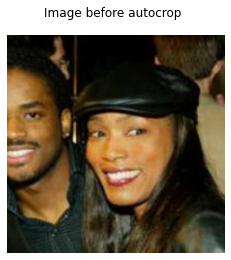

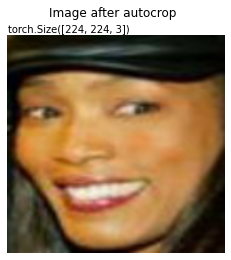

In [ ]:
# Function takes image path and returns image tensor
# after applying MTCNN Face Detection and cropping
def crop_face(path):
  img = Image.open(path)
  image = mtcnn(img)
  img.close()
  return image

# Example of before and after MTCNN face autocrop
sample_img = '/content/lfw/Angela_Bassett/Angela_Bassett_0006.jpg'
fig = plt.figure(figsize=(4, 4))
plt.suptitle("Image before autocrop")
plt.axis('off')
plt.imshow(imread(sample_img))
# Call crop_face to get image tensor after autocrop
img = crop_face(sample_img)
img = img.permute(1, 2, 0)
img += abs(min(img.reshape(-1))) # Normalize data
img /= max(img.reshape(-1))
fig = plt.figure(figsize=(4, 4))
plt.suptitle("Image after autocrop")
plt.axis('off')
plt.text(0,-5,img.shape)
plt.imshow(img);

In [ ]:
# Function takes image tensor and returns preprocessesed tensor
# after cropping and normalizing for pretrained ResNet50 image input
def preprocess(img):
  preprocess = transforms.Compose([
    # transforms.Resize(256),     # Previous method (when not using MTCNN)
    # transforms.CenterCrop(224), # Previous method (when not using MTCNN)
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  )])
  tensor = preprocess(img)
  return tensor

In [ ]:
# Initialize image directory and get list of folders in the directory
img_dir = '/content/lfw/'
folder_list = sorted(os.listdir(img_dir))
img_list = []

# Execute preprocessing, feature extraction for each image
# Append the feature vector to a list of dictionary along with its label and filename
for folder in folder_list:
  dir = os.path.join(img_dir, folder)
  file_count = os.listdir(dir)
  for file in file_count:
    processed_img = crop_face(os.path.join(dir, file)).to(device)
    processed_img = preprocess(processed_img)
    features = feature_extractor(processed_img.unsqueeze(0))
    features = features.to("cpu").detach().numpy().reshape(-1)
    img_list.append({"label": folder, "file_name":file, "feature": features})

### Part 3 Retrieving most similar images (15 points)

Use a nearest neighbor algorithm such as [this](https://scikit-learn.org/stable/modules/neighbors.html) to obtain the 10 most similar images to 5 query images of your choice. Choose the results that best illustrate the effectiveness of your system.


In [ ]:
# Use K-Nearest Neighbors to find 10 similar images
from sklearn.neighbors import NearestNeighbors as NN
from numpy import random
labels = []
files = []
features = []

# Break down the image list to separate nparrays
for img in img_list:
  labels.append(img["label"])
  files.append(img["file_name"])
  features.append(img["feature"])
labels = np.array(labels)
files = np.array(files)
features = np.array(features)

# Initialize and fit the dataset to KNN
# Use defult (Minkowki) metric to get 10 nearest neighbors
nn = NN(n_neighbors=10)
nn.fit(features);

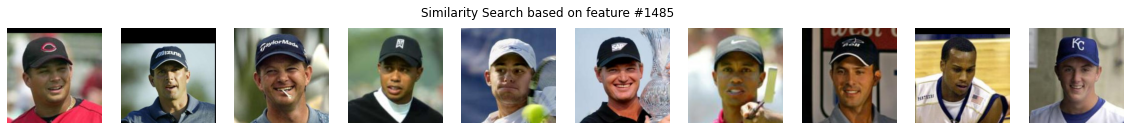

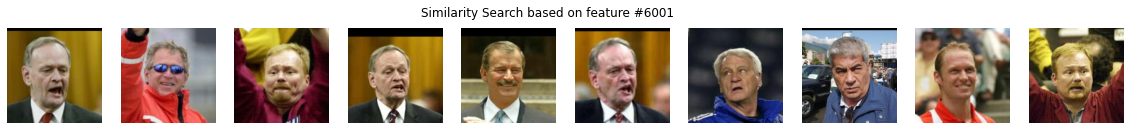

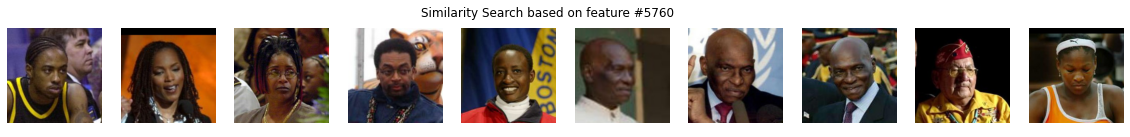

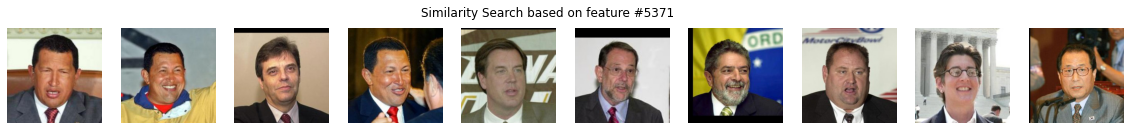

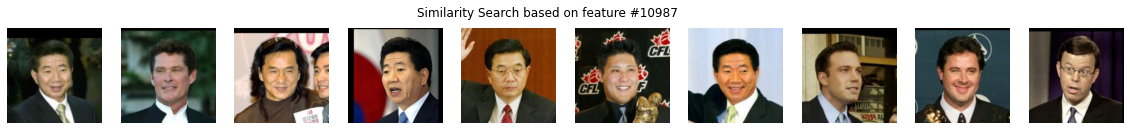

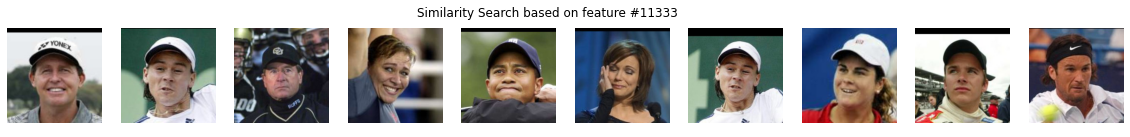

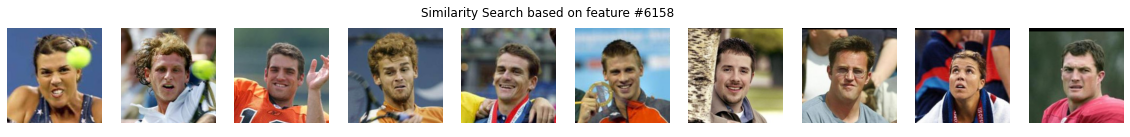

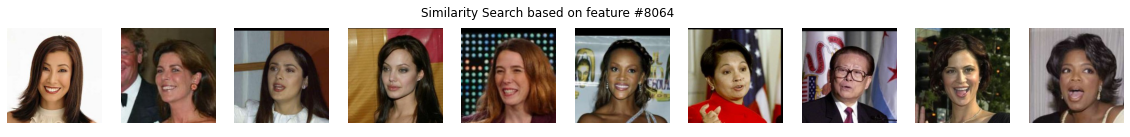

In [ ]:
# List of features to test similarity search
test = [1485,6001, 5760, 5371, 10987,11333, 6158, 8064]
# test = random.randint(1,13200, size=3)

# For each feature, find 10 closest images (including itself)
for i in range(len(test)):
  neighbors = nn.kneighbors([features[test[i]]],return_distance=False)
  neighbors = neighbors[0]
  fig = plt.figure(figsize=(20,2))
  plt.suptitle('Similarity Search based on feature #'+str(test[i]), fontsize=12)
  plt.axis('off')
  # Show 10 images in the same row
  for n in range(len(neighbors)):
    fig.add_subplot(1,len(neighbors), n + 1)
    img = imread(os.path.join(img_dir, labels[neighbors[n]], files[neighbors[n]]))
    plt.axis('off')
    plt.imshow(img)
